Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from matplotlib import pyplot as plt
import keras_tuner as kt
import re
from datetime import time
from geopy.geocoders import Nominatim
import geopandas as gpd
from census import Census
from us import states

Data Ingest

In [65]:
crime_data_init = pd.read_csv("./Crime_Data_from_2020_to_Present.csv")


# Display top five rows
print('Shape of data:', crime_data_init.shape)
crime_data_init.head()

Shape of data: (1004991, 28)


DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA  \
0  211507896  04/11/2021 12:00:00 AM  11/07/2020 12:00:00 AM       845    15   
1  201516622  10/21/2020 12:00:00 AM  10/18/2020 12:00:00 AM      1845    15   
2  240913563  12/10/2024 12:00:00 AM  10/30/2020 12:00:00 AM      1240     9   
3  210704711  12/24/2020 12:00:00 AM  12/24/2020 12:00:00 AM      1310     7   
4  201418201  10/03/2020 12:00:00 AM  09/29/2020 12:00:00 AM      1830    14   

     AREA NAME  Rpt Dist No  Part 1-2  Crm Cd  \
0  N Hollywood         1502         2     354   
1  N Hollywood         1521         1     230   
2     Van Nuys          933         2     354   
3     Wilshire          782         1     331   
4      Pacific         1454         1     420   

                                         Crm Cd Desc  ... Status  Status Desc  \
0                                  THEFT OF IDENTITY  ...     IC  Invest Cont   
1     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  ...     IC  Invest Cont   
2                                  THEFT OF IDENTITY  ...     IC  Invest Cont   
3  THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...  ...     IC  Invest Cont   
4    THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)  ...     IC  Invest Cont   

  Crm Cd 1 Crm Cd 2  Crm Cd 3 Crm Cd 4  \
0    354.0      NaN       NaN      NaN   
1    230.0      NaN       NaN      NaN   
2    354.0      NaN       NaN      NaN   
3    331.0      NaN       NaN      NaN   
4    420.0      NaN       NaN      NaN   

                                   LOCATION Cross Street      LAT       LON  
0   7800    BEEMAN                       AV          NaN  34.2124 -118.4092  
1           ATOLL                        AV     N  GAULT  34.1993 -118.4203  
2  14600    SYLVAN                       ST          NaN  34.1847 -118.4509  
3   6000    COMEY                        AV          NaN  34.0339 -118.3747  
4                   4700    LA VILLA MARINA          NaN  33.9813 -118.4350  

[5 rows x 28 columns]

Columns

In [66]:
df = pd.DataFrame(crime_data_init)
crime_data = df.loc[:, ['DATE OCC', 'TIME OCC', 'AREA NAME', 'Crm Cd Desc', 'Weapon Used Cd']]
print(crime_data)
print(crime_data)

                       DATE OCC  TIME OCC    AREA NAME  \
0        11/07/2020 12:00:00 AM       845  N Hollywood   
1        10/18/2020 12:00:00 AM      1845  N Hollywood   
2        10/30/2020 12:00:00 AM      1240     Van Nuys   
3        12/24/2020 12:00:00 AM      1310     Wilshire   
4        09/29/2020 12:00:00 AM      1830      Pacific   
...                         ...       ...          ...   
1004986  02/02/2025 12:00:00 AM       130      Topanga   
1004987  02/18/2025 12:00:00 AM      1000   Hollenbeck   
1004988  01/30/2025 12:00:00 AM      1554       Newton   
1004989  01/17/2025 12:00:00 AM      1600   Devonshire   
1004990  03/25/2025 12:00:00 AM      1235      Mission   

                                               Crm Cd Desc  Weapon Used Cd  
0                                        THEFT OF IDENTITY             NaN  
1           ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT           200.0  
2                                        THEFT OF IDENTITY             N

Shape

In [67]:
violent_crimes = [
    'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
    'INTIMATE PARTNER - SIMPLE ASSAULT',
    'ROBBERY',
    'CRIMINAL HOMICIDE',
    'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
    'RAPE, FORCIBLE',
    'MANSLAUGHTER, NEGLIGENT',
    'BATTERY - SIMPLE ASSAULT',
    'LYNCHING'
]
crime_data['Violent'] = (
    crime_data['Weapon Used Cd'].notna() | crime_data['Crm Cd Desc'].isin(violent_crimes)
).astype(int)

crime_data['DATE OCC'] = pd.to_datetime(crime_data['DATE OCC'], errors='coerce')

crime_data['Month'] = crime_data['DATE OCC'].dt.month

crime_data['Weekday'] = crime_data['DATE OCC'].dt.day_name()

crime_data['TIME OCC'] = (
    crime_data['TIME OCC']
    .astype(str)
    #leading zero
    .str.zfill(4)
    #makes into time
    .str.replace(r'(\d{2})(\d{2})', r'\1:\2', regex=True)
)
#actual time measure
crime_data['TIME OCC'] = pd.to_datetime(crime_data['TIME OCC'], format='%H:%M', errors='coerce').dt.time

#create dummies for area
area_dummies = pd.get_dummies(crime_data['AREA NAME'], prefix='AREA')
crime_data = pd.concat([crime_data, area_dummies], axis=1)
#print(crime_data['AREA NAME'].unique())
#change dataframe contents
crime_data = crime_data.loc[:, ['Month', 'Weekday', 'TIME OCC', 'Violent', 'AREA_N Hollywood', 'AREA_Van Nuys', 'AREA_Wilshire', 'AREA_Pacific', 'AREA_Hollenbeck', 'AREA_Southwest',
 'AREA_Northeast', 'AREA_Devonshire', 'AREA_Topanga', 'AREA_Hollywood', 'AREA_Olympic', 'AREA_Southeast',
 'AREA_Newton', 'AREA_Foothill', 'AREA_Mission', 'AREA_Rampart', 'AREA_Central', 'AREA_West LA', 'AREA_77th Street',
 'AREA_West Valley', 'AREA_Harbor']]

print(crime_data.shape)
print(crime_data.head())

C:\Users\winni\AppData\Local\Temp\ipykernel_99492\1984563543.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_data['DATE OCC'] = pd.to_datetime(crime_data['DATE OCC'], errors='coerce')


(1004991, 25)
   Month   Weekday  TIME OCC  Violent  AREA_N Hollywood  AREA_Van Nuys  \
0     11  Saturday  08:45:00        0              True          False   
1     10    Sunday  18:45:00        1              True          False   
2     10    Friday  12:40:00        0             False           True   
3     12  Thursday  13:10:00        0             False          False   
4      9   Tuesday  18:30:00        0             False          False   

   AREA_Wilshire  AREA_Pacific  AREA_Hollenbeck  AREA_Southwest  ...  \
0          False         False            False           False  ...   
1          False         False            False           False  ...   
2          False         False            False           False  ...   
3           True         False            False           False  ...   
4          False          True            False           False  ...   

   AREA_Southeast  AREA_Newton  AREA_Foothill  AREA_Mission  AREA_Rampart  \
0           False        False 

Sin-Cosine Transformations

In [68]:
crime_data_cyclic = crime_data.copy()

#Month
if crime_data_cyclic['Month'].dtype == 'O':  # strings
    month_map = {m: i for i, m in enumerate(pd.date_range('2000-01-01', periods=12, freq='MS').month_name(), start=1)}
    crime_data_cyclic['Month_num'] = crime_data_cyclic['Month'].map(lambda x: month_map.get(str(x).strip().title(), np.nan))
else:
    crime_data_cyclic['Month_num'] = pd.to_numeric(crime_data_cyclic['Month'], errors='coerce').clip(1, 12)

#Weekday
if crime_data_cyclic['Weekday'].dtype == 'O':  # strings
    wd_names = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    wd_map = {name: i for i, name in enumerate(wd_names)}
    crime_data_cyclic['Weekday_num'] = crime_data_cyclic['Weekday'].map(lambda x: wd_map.get(str(x).strip().title(), np.nan))
else:
    wd = pd.to_numeric(crime_data_cyclic['Weekday'], errors='coerce')
    crime_data_cyclic['Weekday_num'] = np.where((wd >= 1) & (wd <= 7), (wd - 1), wd)
    crime_data_cyclic.loc[~crime_data_cyclic['Weekday_num'].between(0,6), 'Weekday_num'] = np.nan

#TIME OCC as minutes since midnight [0....1439]
def to_minutes_since_midnight(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, time):
        return x.hour * 60 + x.minute
    s = str(x).strip()
    if ':' in s:
        try:
            hh, mm = s.split(':', 1)
            hh, mm = int(hh), int(mm)
        except Exception:
            return np.nan
    else:
        s = re.sub(r'\D', '', s)
        if not s:
            return np.nan
        s = s.zfill(4)[-4:]
        hh, mm = int(s[:2]), int(s[2:])
    if hh == 24 and mm == 0:
        hh, mm = 0, 0
    if not (0 <= hh <= 23 and 0 <= mm <= 59):
        return np.nan
    return hh * 60 + mm

crime_data_cyclic['Time_min'] = crime_data_cyclic['TIME OCC'].map(to_minutes_since_midnight)

#cyclic transforms
crime_data_cyclic['Month_sin']   = np.sin(2 * np.pi * (crime_data_cyclic['Month_num'] - 1) / 12)
crime_data_cyclic['Month_cos']   = np.cos(2 * np.pi * (crime_data_cyclic['Month_num'] - 1) / 12)

crime_data_cyclic['Weekday_sin'] = np.sin(2 * np.pi * (crime_data_cyclic['Weekday_num']) / 7)
crime_data_cyclic['Weekday_cos'] = np.cos(2 * np.pi * (crime_data_cyclic['Weekday_num']) / 7)

crime_data_cyclic['Time_sin']    = np.sin(2 * np.pi * (crime_data_cyclic['Time_min']) / 1440)
crime_data_cyclic['Time_cos']    = np.cos(2 * np.pi * (crime_data_cyclic['Time_min']) / 1440)

#data with sin-consin transforms included
crime_data_cyclic = crime_data_cyclic.loc[:, ['Month_sin', 'Month_cos', 'Weekday_sin', 'Weekday_cos', 'Time_sin', 'Time_cos', 'Violent', 'AREA_N Hollywood', 'AREA_Van Nuys', 'AREA_Wilshire', 'AREA_Pacific', 'AREA_Hollenbeck', 'AREA_Southwest',
 'AREA_Northeast', 'AREA_Devonshire', 'AREA_Topanga', 'AREA_Hollywood', 'AREA_Olympic', 'AREA_Southeast',
 'AREA_Newton', 'AREA_Foothill', 'AREA_Mission', 'AREA_Rampart', 'AREA_Central', 'AREA_West LA', 'AREA_77th Street',
 'AREA_West Valley', 'AREA_Harbor']]

print(crime_data_cyclic.shape)
crime_data_cyclic.head()

(1004991, 28)


Month_sin     Month_cos  Weekday_sin  Weekday_cos  Time_sin  Time_cos  \
0  -0.866025  5.000000e-01    -0.974928    -0.222521  0.751840 -0.659346   
1  -1.000000 -1.836970e-16    -0.781831     0.623490 -0.980785  0.195090   
2  -1.000000 -1.836970e-16    -0.433884    -0.900969 -0.173648 -0.984808   
3  -0.500000  8.660254e-01     0.433884    -0.900969 -0.300706 -0.953717   
4  -0.866025 -5.000000e-01     0.781831     0.623490 -0.991445  0.130526   

   Violent  AREA_N Hollywood  AREA_Van Nuys  AREA_Wilshire  ...  \
0        0              True          False          False  ...   
1        1              True          False          False  ...   
2        0             False           True          False  ...   
3        0             False          False           True  ...   
4        0             False          False          False  ...   

   AREA_Southeast  AREA_Newton  AREA_Foothill  AREA_Mission  AREA_Rampart  \
0           False        False          False         False         False   
1           False        False          False         False         False   
2           False        False          False         False         False   
3           False        False          False         False         False   
4           False        False          False         False         False   

   AREA_Central  AREA_West LA  AREA_77th Street  AREA_West Valley  AREA_Harbor  
0         False         False             False             False        False  
1         False         False             False             False        False  
2         False         False             False             False        False  
3         False         False             False             False        False  
4         False         False             False             False        False  

[5 rows x 28 columns]

Shuffle Data

In [ ]:
np.random.seed(0)
indices = list(crime_data_cyclic.index)
print(indices)
shuffled_indices = np.random.permutation(indices)
print(shuffled_indices)
crime_data_cyclic = crime_data_cyclic.reindex(index=shuffled_indices)
print(crime_data_cyclic.head)

[520308, 259754, 265727, 483590, 863362, 353315, 792226, 189493, 584887, 106449, 1003015, 386031, 707604, 126977, 692744, 217346, 382136, 517704, 418419, 475715, 988725, 228487, 544175, 783650, 339169, 158984, 371335, 801771, 532343, 310467, 532611, 373817, 836275, 805443, 653377, 612259, 600563, 137887, 53888, 523131, 447299, 70765, 280363, 222366, 359984, 866152, 565058, 603579, 7452, 871848, 837515, 314272, 98746, 437587, 282727, 91897, 76279, 692101, 463054, 699168, 278191, 863821, 1001210, 654762, 1000904, 978530, 617095, 379315, 340009, 201447, 943048, 702763, 259459, 668902, 327672, 99918, 303821, 530338, 299864, 797733, 560717, 35796, 767832, 214335, 375167, 872227, 431326, 513719, 606117, 170044, 519307, 301322, 754785, 373956, 733828, 153864, 55567, 415857, 101628, 993456, 300097, 342732, 888054, 908821, 160219, 390068, 481187, 983584, 359418, 776139, 503701, 369343, 698568, 835898, 783918, 91260, 878627, 975733, 55735, 260357, 984093, 611150, 590060, 677154, 273093, 997624, 

Define Outcome Features

In [72]:
Y = crime_data_cyclic['Violent']
print(Y.shape)
X = crime_data_cyclic[['Month_sin', 'Month_cos', 'Weekday_sin', 'Weekday_cos', 'Time_sin', 'Time_cos', 'Violent', 'AREA_N Hollywood', 'AREA_Van Nuys', 'AREA_Wilshire', 'AREA_Pacific', 'AREA_Hollenbeck', 'AREA_Southwest',
 'AREA_Northeast', 'AREA_Devonshire', 'AREA_Topanga', 'AREA_Hollywood', 'AREA_Olympic', 'AREA_Southeast',
 'AREA_Newton', 'AREA_Foothill', 'AREA_Mission', 'AREA_Rampart', 'AREA_Central', 'AREA_West LA', 'AREA_77th Street',
 'AREA_West Valley', 'AREA_Harbor']]
print(X.shape)

(1004991,)
(1004991, 28)


Data Splits

In [73]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=1234)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=1234)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(602994, 28)
(602994,)
(200998, 28)
(200998,)
(200999, 28)
(200999,)


Data Standardization

In [ ]:

print(X_train.describe())

#auto-create Standardization
scaler = StandardScaler()
scaler.fit(X_train)
#or do manually with
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
#then do "X_train_std = (X_train - mean) / std" for each

X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

#same with Y
scaler.fit(Y_train.values.reshape(-1, 1))

Y_train_std = scaler.transform(Y_train.values.reshape(-1, 1))
Y_val_std = scaler.transform(Y_val.values.reshape(-1, 1))
Y_test_std = scaler.transform(Y_test.values.reshape(-1, 1))

          Month_sin     Month_cos    Weekday_sin    Weekday_cos  \
count  6.029940e+05  6.029940e+05  602994.000000  602994.000000   
mean   1.124423e-02  1.009963e-02      -0.011524      -0.016336   
std    7.041994e-01  7.098426e-01       0.706307       0.707624   
min   -1.000000e+00 -1.000000e+00      -0.974928      -0.900969   
25%   -5.000000e-01 -5.000000e-01      -0.781831      -0.900969   
50%    1.224647e-16  6.123234e-17       0.000000      -0.222521   
75%    8.660254e-01  8.660254e-01       0.781831       0.623490   
max    1.000000e+00  1.000000e+00       0.974928       1.000000   

            Time_sin       Time_cos        Violent  
count  602994.000000  602994.000000  602994.000000  
mean       -0.207109      -0.066166       0.325781  
std         0.663320       0.716056       0.468666  
min        -1.000000      -1.000000       0.000000  
25%        -0.866025      -0.793353       0.000000  
50%        -0.342020      -0.130526       0.000000  
75%         0.382683     

Scatterplt Matrix

In [77]:
#dataframe
rewrap_x = pd.DataFrame(
    X_train_std,
    columns=X_train.columns,
    index=X_train.index
)
rewrap_x["Violent"] = Y_train_std.ravel()
#pairplot
#sns.pairplot(rewrap_x, diag_kind="kde")
#plt.title("Pair-wise Correlation of Features")
#plt.show()

Correlation Matrix

<function matplotlib.pyplot.show(close=None, block=None)>

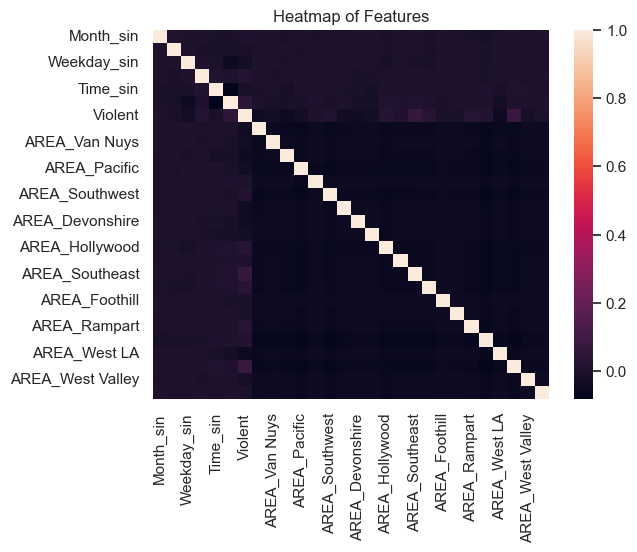

In [78]:
#matrix
corr_mat = rewrap_x.corr()
sns.heatmap(corr_mat)
plt.title("Heatmap of Features")
plt.show

Baseline Model

In [79]:
#baselines
baseline_std = Y_train_std.mean()
print(baseline_std)
baseline_orig = scaler.inverse_transform([[baseline_std]])[0, 0]
print(baseline_orig)

-4.940854620513803e-17
0.3257810193799607


Improvement Over Baseline with Tensorflow

In [80]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=(num_features,),  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.keras.initializers.Ones(),  # initialize params to 1
      bias_initializer=tf.keras.initializers.Ones(),    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use GD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)

  # Finally, compile the model. This finalizes the graph for training.
  # We specify the MSE loss and the optimizer above
  model.compile(optimizer=optimizer, loss="mse")
    
  return model

C:\Users\winni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
18844/18844 ━━━━━━━━━━━━━━━━━━━━ 14s 705us/step - loss: 2.4450 - val_loss: 0.0049
Epoch 2/5
18844/18844 ━━━━━━━━━━━━━━━━━━━━ 13s 696us/step - loss: 0.0018 - val_loss: 4.3490e-06
Epoch 3/5
18844/18844 ━━━━━━━━━━━━━━━━━━━━ 13s 690us/step - loss: 1.5912e-06 - val_loss: 1.5636e-08
Epoch 4/5
18844/18844 ━━━━━━━━━━━━━━━━━━━━ 13s 690us/step - loss: 1.3020e-08 - val_loss: 1.1464e-08
Epoch 5/5
18844/18844 ━━━━━━━━━━━━━━━━━━━━ 13s 688us/step - loss: 1.1462e-08 - val_loss: 1.1412e-08


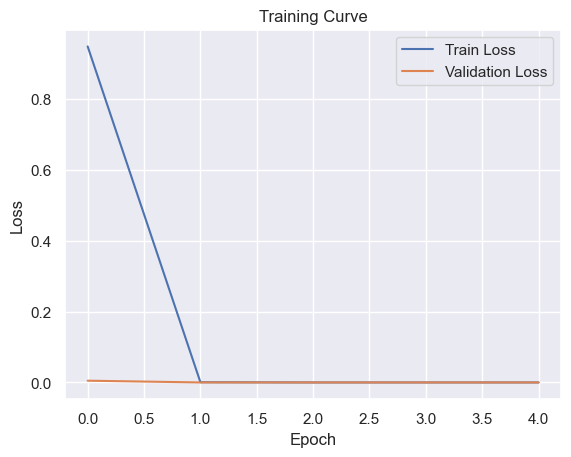

In [ ]:
tf.random.set_seed(0)
# 2. Build and compile model
model_tf = build_model(num_features=X_train_std.shape[1], learning_rate = 0.0001)

# 3. Fit the model
#reshapes
y_train  = np.asarray(Y_train_std).reshape(-1, 1)
y_val = np.asarray(Y_val_std).reshape(-1, 1)

#model
fit_model = model_tf.fit(
    X_train_std, y_train,
    validation_data=(X_val_std, y_val),
    epochs=5,
    verbose=1
)

#plot
plt.figure()
plt.plot(fit_model.epoch, fit_model.history["loss"], label="Train Loss")
plt.plot(fit_model.epoch, fit_model.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.legend()
plt.show()

HyperParameter Tuning

In [ ]:
learning_rate = 0.003
num_epochs = 500

model_tf = build_model(num_features=X_train_std.shape[1], learning_rate = learning_rate)

# 3. Fit the model
y_train = np.asarray(Y_train_std).reshape(-1, 1)
y_val = np.asarray(Y_val_std).reshape(-1, 1)
y_test = np.asarray(Y_test_std).reshape(-1, 1)

fit_model = model_tf.fit(
    X_train_std, y_train,
    validation_data=(X_val_std, y_val),
    epochs=num_epochs,
    verbose=1
)
#plot
plt.figure()
plt.plot(fit_model.epoch, fit_model.history["loss"], label="Train Loss")
plt.plot(fit_model.epoch, fit_model.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.legend()
plt.show()

#weight and bias
W, bias = model_tf.layers[0].get_weights()
print(pd.Series(W.ravel(), index=X_train.columns))
print("Bias: ", float(bias[0]))

#difference
diff = (fit_model.history["val_loss"][-1]) - fit_model.history["loss"][-1]
print("Difference: ", diff)


Compute MSE

In [ ]:
#mse
print(model_tf.evaluate(X_train_std, y_train))
print(model_tf.evaluate(X_test_std, y_test))

y_test_pred = model_tf.predict(X_test_std).ravel()
y_obs_test = Y_test_std.ravel()

#scatter
plt.scatter(y_obs_test, y_test_pred)
plt.plot([-3, 3], [-3, 3], "red")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Predicted vs. Observed")
plt.legend()
plt.show()